#DAT-25-NYC Final Project: Yelp Review Text Analysis
##Goal: Predict the number of stars on any given review based on the review text

Import appropriate libraries for analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

###Read in review data
###Merge "review" table with "business" table to add business category and location

In [3]:
rvws = pd.read_csv("data\yelp_academic_dataset_review.csv")
headers = ['categories','business_id','city','state']
business = pd.read_csv("data\yelp_academic_dataset_business.csv", usecols = headers)
reviews_full = pd.merge(rvws, business, on = 'business_id')
reviews_full.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2,"[u'Doctors', u'Health & Medical']",AZ,Phoenix
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2,"[u'Doctors', u'Health & Medical']",AZ,Phoenix
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1,"[u'Doctors', u'Health & Medical']",AZ,Phoenix
3,KBLW4wJA_fwoWmMhiHRVOA,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,0,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-03-02,review,0,"[u'Doctors', u'Health & Medical']",AZ,Phoenix
4,zvJCcrpm2yOZrxKffwGQLA,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-05-15,review,2,"[u'Doctors', u'Health & Medical']",AZ,Phoenix


###Modify dataframe to include only restaurants and one location (Avondale)

In [4]:
cat = reviews_full['categories']
rest = []

for x in range(len(cat)):
    if "Restaurants" in cat[x]:
        rest.append(1)
    elif "Food" in cat[x]:
        rest.append(1)
    else:
        rest.append(0)

reviews_full['restaurant'] = rest
reviews_full = reviews_full[reviews_full['restaurant'] == 1]
reviews_full = reviews_full.reset_index(drop=True)

reviews = reviews_full[reviews_full['city'] == 'Avondale']
reviews = reviews.reset_index(drop=True)
reviews.to_csv("yelp_dataset_reviews_Avondale")
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful,categories,state,city,restaurant
0,cTT7cTG6SuVOc1ib6gwhHA,uPez-RSvBOxO1AWTGMtB7g,3.5 Stars\n\nEvery clerk there is friendly. N...,2,j5qC_y7mRRWNUqFdR8Z1_A,1,3,2013-10-13,review,3,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
1,kcgYbndUk0e07YusRAcTrg,Q6L6oNvb60GMqdN5xxSRiw,"Simple and small, haven't tried their water or...",0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-07-29,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
2,vrIuFfhpUyOA_m9goXVWxw,yVV5W3cDRYow2nEPQDN-EQ,Ashley is really awesome she is always with a ...,0,j5qC_y7mRRWNUqFdR8Z1_A,1,5,2014-10-01,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
3,l72Kt2u68aLuJVX9J8J0hQ,PLEltvCMh8u7FlxFf225og,Great old time ice cream shop from the '20s. R...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,5,2014-10-04,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1
4,Iqw0kVKBtgo4Vn8AtG2kRA,BuwZ9XJgenH9mET_zCCbrA,This is a small family owned business so I'll ...,0,j5qC_y7mRRWNUqFdR8Z1_A,0,3,2014-11-16,review,0,"[u'Food', u'Ice Cream & Frozen Yogurt']",AZ,Avondale,1


Value counts for each star so we can get a general sense of distribution:
5    1260
4    1097
3     488
1     393
2     322
dtype: int64


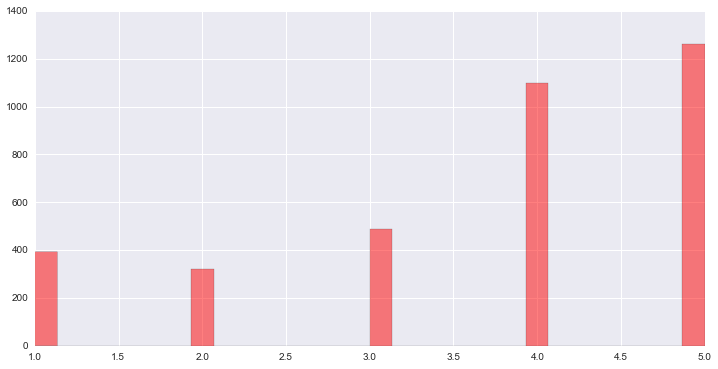

In [5]:
text = reviews['text']
stars = reviews['stars']

print "Value counts for each star so we can get a general sense of distribution:"
print stars.value_counts()
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
stars.hist(color='red', alpha=0.5, bins = 30)

###Create features based on text data:
- Text length
- Sentiment score based on bag of good & bad words

In [7]:
## Create features based on the text.
## First, append text_length to data frame which signifies the length of the review text.
## Download list of positive / negative from here: http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

text_length = []
for x in range(len(reviews['text'])):
    text_length.append(len(text[x]))

reviews['text_length'] = text_length

positives = open('data/positive-words.txt').read()
negatives = open('data/negative-words.txt').read()
pos_word_list = positives.split('\n')
neg_word_list = negatives.split('\n')
print "POSITIVE WORDS: {}".format(pos_word_list[:20])
print "NEGATIVE WORDS: {}".format(neg_word_list[:20])

POSITIVE WORDS: ['', '', 'a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments']
NEGATIVE WORDS: ['', '', '2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded']


###Define two functions:
- review_to_wordlist() to change review text into a list of words
- word_count() to count the number of words in a given list that are contained in another list, e.g. number of positive words in a given sentence

In [8]:
def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.

    review_text = review   
    
    # 1. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)

    # 2. Convert words to lower case and split them
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return(words)

def word_count(sentence, word_list):
    count = 0
    for x in review_to_wordlist(sentence):
        if x in word_list:
            count += 1
    
    return count

In [9]:
%%time

## Use positive and negative words to give each piece of a text a sentiment score. The sentiment score ranges from
## -1 (all negative words) to 1 (all positive words).

sentiment = []
pos_neg_ratio = []
count = 0

for x in text:
    positive = word_count(x, pos_word_list)
    negative = word_count(x, neg_word_list)
    if (negative > 0):
        ratio = float(positive)/negative
    else:
        ratio = positive
    
    if ((positive + negative) == 0):
        sent = 1
    else:
        sent = ((positive-negative)/(float(positive)+negative))+1
        
    sentiment.append(sent)
    pos_neg_ratio.append(ratio)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['sentiment'] = sentiment
reviews['pos_neg_ratio'] = pos_neg_ratio
reviews.head()

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Wall time: 29 s


In [10]:
feature_list = ['text_length', 'pos_neg_ratio', 'sentiment']
features = reviews[feature_list]
stars = reviews['stars']

##Train / test based on text length, positive/negative ratio and sentiment score

In [11]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, stars, test_size=0.3, random_state=12)
extra = ExtraTreesClassifier()
mnbayes = MultinomialNB()
svc = SVC(C=1, probability=True)
adaboost = AdaBoostClassifier()
logreg = LogisticRegression(C=1)

extra.fit(x_train, y_train)
mnbayes.fit(x_train, y_train)
svc.fit(x_train, y_train)
adaboost.fit(x_train, y_train)
logreg.fit(x_train, y_train)

print "Extra Trees score: {}".format(extra.score(x_test, y_test))
print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
print "SVC Score: {}".format(svc.score(x_test, y_test))
print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
print "Logistic Regression Score: {}".format(logreg.score(x_test, y_test))

Extra Trees score: 0.359550561798
Multinomial Naive Bayes score: 0.424157303371
SVC Score: 0.34925093633
Ada Boosted Decision Tree Score: 0.420411985019
Logistic Regression Score: 0.453183520599


##Classifiers did not score well on 1-5 scale of stars, so we will adjust to binary prediction by grouping 4 & 5 star reviews and 1-3 star reviews as "good" and "bad".

In [12]:
star_threshold = 4

reviews['good'] = (reviews['stars'] >= star_threshold)
good = reviews['good']
good = good.map({True: 1, False: 0})

###Define functions for:
- Plotting ROC curve
- Fitting 5 models (Extra Forests, MN Bayes, SVM SVC, AdaBoosted Decision Tree and Logistic Regression)

In [13]:
def plot_roc_curve(target_test, target_predicted_proba, this_label):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label= this_label + ', ROC Area = %0.3f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC')
    plt.legend(loc="lower right")

## Define a function to train & test 5 different classifiers, output scores and AUC

def test_classifiers(x_train, x_test, y_train, y_test, features, target):

    extra.fit(x_train, y_train)
    mnbayes.fit(x_train, y_train)
    svc.fit(x_train, y_train)
    adaboost.fit(x_train, y_train)
    logreg.fit(x_train, y_train)

    print "Extra Forest score: {}".format(extra.score(x_test, y_test))
    print "Multinomial Naive Bayes score: {}".format(mnbayes.score(x_test, y_test))
    print "SVC Score: {}".format(svc.score(x_test, y_test))
    print "Ada Boosted Decision Tree Score: {}".format(adaboost.score(x_test, y_test))
    print "Logistic Regression Score: {}\n".format(logreg.score(x_test, y_test))

    print "Extra Forest AUC: {}".format(cross_val_score(extra, features, good, cv=3, scoring='roc_auc').mean())
    print "Multinomial Naive Bayes AUC: {}".format(cross_val_score(mnbayes, features, good, cv=3, scoring='roc_auc').mean())
    print "SVC AUC: {}".format(cross_val_score(svc, features, good, cv=3, scoring='roc_auc').mean())
    print "Ada Boosted Decision Tree AUC: {}".format(cross_val_score(adaboost, features, good, cv=3, scoring='roc_auc').mean())
    print "Logistic Regression AUC: {}".format(cross_val_score(logreg, features, good, cv=3, scoring='roc_auc').mean())

    plot_roc_curve(y_test, extra.predict_proba(x_test), "Extra Trees")
    plot_roc_curve(y_test, mnbayes.predict_proba(x_test), "MN Bayes")
    plot_roc_curve(y_test, svc.predict_proba(x_test), "SVM SVC")
    plot_roc_curve(y_test, adaboost.predict_proba(x_test), "Ada Boost")
    plot_roc_curve(y_test, logreg.predict_proba(x_test), "Logistic Regression")

Extra Forest score: 0.705056179775
Multinomial Naive Bayes score: 0.756554307116
SVC Score: 0.698501872659
Ada Boosted Decision Tree Score: 0.772471910112
Logistic Regression Score: 0.7734082397

Extra Forest AUC: 0.707552980916
Multinomial Naive Bayes AUC: 0.785258161787
SVC AUC: 0.694393418732
Ada Boosted Decision Tree AUC: 0.801001525025
Logistic Regression AUC: 0.812701576286


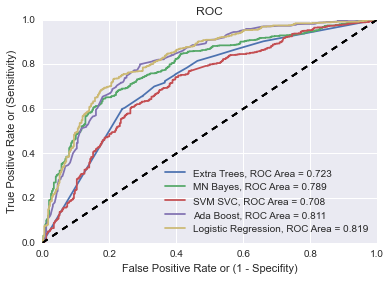

In [14]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

### After looking at list of common words, "service" appears in about 1/3 of reviews. Thus, add a metric labeled "service sentiment" that gauges sentiment around the word service, when it appears. Also add a metric that measures how much of a review consists of stop words.

In [18]:
service = []
stops = []
stop_words = set(stopwords.words("english"))

for i in range(len(text)):
    x = review_to_wordlist(text[i])
    if 'service' in x:
        service_loc = x.index('service')
        near_service = x[int(service_loc-6):int(service_loc+6)]
        pos_service = word_count(' , '.join(near_service).strip(), pos_word_list)
        neg_service = word_count(' , '.join(near_service).strip(), neg_word_list)
        if pos_service > 0 or neg_service > 0:
            service.append((float((pos_service-neg_service))/(pos_service+neg_service))+1)
        else:
            service.append(1)
    else:
        service.append(1)
    stops.append(float(word_count(text[i], stop_words))/len(x))

reviews['service_sentiment'] = service
reviews['stop_word_ratio'] = stops

feature_list = ['text_length', 'pos_neg_ratio', 'sentiment', 'service_sentiment', 'stop_word_ratio']
features = reviews[feature_list]
stars = reviews['stars']
features.head()

,text_length,pos_neg_ratio,sentiment,service_sentiment,stop_word_ratio
0,616,4.000000,2.0,2,0.450450
1,722,5.000000,2.0,1,0.479167
2,196,6.000000,2.0,1,0.540541
3,278,3.000000,1.5,1,0.442308
4,1167,0.428571,0.6,1,0.538462


Extra Forest score: 0.719101123596
Multinomial Naive Bayes score: 0.75
SVC Score: 0.705056179775
Ada Boosted Decision Tree Score: 0.780898876404
Logistic Regression Score: 0.783707865169

Extra Forest AUC: 0.742294725362
Multinomial Naive Bayes AUC: 0.782075082602
SVC AUC: 0.698771800611
Ada Boosted Decision Tree AUC: 0.801966486193
Logistic Regression AUC: 0.820930069089


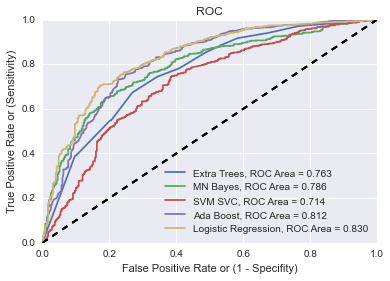

In [19]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

###Add a sentiment score for common vs. uncommon words, using min_df and max_df in CountVectorizer

In [21]:
vect = CountVectorizer(decode_error = 'ignore', stop_words = 'english', min_df=0.005)
vect.fit(text)
text_dtm = vect.transform(text)
text_array = text_dtm.toarray()

count_vocab = np.sum(text_array, axis=0)
text_freq = vect.get_feature_names()

vect_uncommon = CountVectorizer(decode_error = 'ignore', stop_words = 'english', max_df=0.995)
vect_uncommon.fit(text)
text_unfreq = vect_uncommon.get_feature_names()

print len(text_freq)
print len(text_unfreq)

freq_pos = [w for w in pos_word_list if w in text_freq]
freq_neg = [w for w in neg_word_list if w in text_freq]
unfreq_pos = [w for w in pos_word_list if w in text_unfreq]
unfreq_neg = [w for w in neg_word_list if w in text_unfreq]

C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


1225
10944


In [23]:
%%time
freq_sentiment = []
unfreq_sentiment = []
count = 0

for x in text:
    common_positive = word_count(x, freq_pos)
    common_negative = word_count(x, freq_neg)
    uncommon_positive = word_count(x, unfreq_pos)
    uncommon_negative = word_count(x, unfreq_neg)
    
    if ((common_positive + common_negative) == 0):
        freq_sent = 1
    else:
        freq_sent = ((common_positive - common_negative)/(float(common_positive)+common_negative))+1
    
    if ((uncommon_positive + uncommon_negative) == 0):
        unfreq_sent = 1
    else:
        unfreq_sent = ((uncommon_positive - uncommon_negative)/(float(uncommon_positive)+uncommon_negative))+1
    
    freq_sentiment.append(freq_sent)
    unfreq_sentiment.append(unfreq_sent)
    if count % 1000 == 0:
        print "Scoring text #{}".format(count)
    count += 1

reviews['freq_sentiment'] = freq_sentiment
reviews['unfreq_sentiment'] = unfreq_sentiment

Scoring text #0
Scoring text #1000
Scoring text #2000
Scoring text #3000
Wall time: 7.69 s


###Feature Set:

In [24]:
feature_list = ['text_length', 'pos_neg_ratio', 'sentiment', 'service_sentiment', 
                'stop_word_ratio', 'freq_sentiment', 'unfreq_sentiment']

features = reviews[feature_list]
stars = reviews['stars']
features.head()

,text_length,pos_neg_ratio,sentiment,service_sentiment,stop_word_ratio,freq_sentiment,unfreq_sentiment
0,616,4.000000,2.0,2,0.450450,2.000000,2.000000
1,722,5.000000,2.0,1,0.479167,2.000000,2.000000
2,196,6.000000,2.0,1,0.540541,2.000000,2.000000
3,278,3.000000,1.5,1,0.442308,1.800000,1.500000
4,1167,0.428571,0.6,1,0.538462,0.666667,0.444444


Extra Forest score: 0.737827715356
Multinomial Naive Bayes score: 0.748127340824
SVC Score: 0.716292134831
Ada Boosted Decision Tree Score: 0.776217228464
Logistic Regression Score: 0.779962546816

Extra Forest AUC: 0.751936425421
Multinomial Naive Bayes AUC: 0.778241798598
SVC AUC: 0.70946123775
Ada Boosted Decision Tree AUC: 0.807252274844
Logistic Regression AUC: 0.821118435604


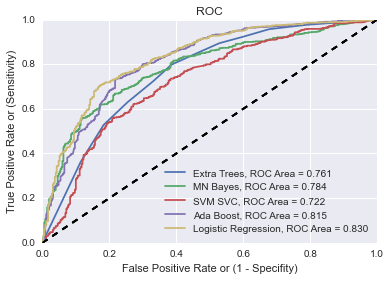

In [25]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(features, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, features, good)

###Additional features based on high level text characteristics yielded marginally better results. Now we will vectorize the text using Tfidf and use this vectorization as feature set:
- Lemmatize the text
- Remove stop words
- Remove symbols / non-letters

In [26]:
%%time

stop_words = set(stopwords.words("english"))
count = 0
text_clean = text
lemm = WordNetLemmatizer()

## Before cleaning the text, we'll vectorize the uncleaned text to see how the difference it makes.
vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
dirty_text_length = len(vect.vocabulary_)

for x in range(len(text_clean)):
    count +=1
    if count % 1000 == 0:
        print "Cleaning text #{}...".format(count)
    w = text[x]
    w = re.sub("[^a-zA-Z]"," ", w)    # gets rid of non-letters and substitutes it with a space
    w = word_tokenize(w)    # Tokenizes the sentence, breaking it up into a list of words rather than one long string.
    w = [lemm.lemmatize(z) for z in w if not z in stop_words]    # deletes stop words from the text, or words that don't add any meaning
    text_clean[x] = w

text_clean = [' , '.join(z).strip() for z in text_clean]

Cleaning text #1000...
Cleaning text #2000...
Cleaning text #3000...
Wall time: 7min 34s


C:\Users\samchu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
%%time

vect = CountVectorizer(decode_error = 'ignore')
vect.fit(text_clean)
clean_text_length = len(vect.vocabulary_)
print "Text without any edits had {} unique tokens.".format(dirty_text_length)
print "Text after removing stop words and lemmatizing, the text had {} unique tokens.".format(clean_text_length)

## Vectorize the text with sklearn's TfidfVectorizer... This weights each word depending on the Tf-idf importance.

vect = TfidfVectorizer(stop_words='english', ngram_range = (1,1), decode_error = 'ignore')
vect.fit(text_clean)

## Map the vectorized text to an array and Pandas dataframe

text_dtm = vect.transform(text_clean)
text_array = text_dtm.toarray()
text_df = pd.DataFrame(text_array, columns = vect.get_feature_names())

Text without any edits had 11232 unique tokens.
Text after removing stop words and lemmatizing, the text had 10159 unique tokens.
Wall time: 894 ms


Extra Forest score: 0.786516853933
Multinomial Naive Bayes score: 0.723782771536
SVC Score: 0.672284644195
Ada Boosted Decision Tree Score: 0.814606741573
Logistic Regression Score: 0.828651685393

Extra Forest AUC: 0.801682589526
Multinomial Naive Bayes AUC: 0.857522618363
SVC AUC: 0.881061759872
Ada Boosted Decision Tree AUC: 0.844788624324
Logistic Regression AUC: 0.887655440687
Wall time: 21min 52s


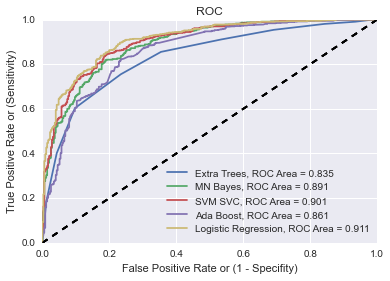

In [29]:
%%time
x_train, x_test, y_train, y_test = cross_validation.train_test_split(text_array, good, test_size=0.3, random_state=12)

test_classifiers(x_train, x_test, y_train, y_test, text_array, good)